In [87]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Conv2D, Dropout, Input
from IPython.display import clear_output

Team Members: Andrew Gillock (apg2255), April Kim (hk22849), Olivia Lee (rl29986), Parthiv Borgohain (pb25347)

## Problem Overview

You work for a board game company. Your company is considering using RL to find good playing strategies actions when playing the game. Your company is very new to RL, so your boss wants you to explore RL on a simple game first. You will do this for a variation of Connect-4, called PopOut. Rules for the basic version of Connect-4 and PopOut can be found at: https://en.wikipedia.org/wiki/Connect_Four. The basic idea of PopOut is that on your turn you can drop a checker into a column that has open spaces (like in standard connect4) OR you can choose to remove one of your checkers from the bottom row, if one of your checkers is on the bottom row. If you remove a checker from the bottom row then the checkers above the one you remove will then drop down one row. You cannot remove one of your opponent’s checkers on the bottom row. You will solve this problem using a self-play reinforcement learning agent.

## Specifics


1. Build a reinforcement learning agent that plays PopOut. We have built 2 simple engines in class that did not perform very well on Pong. Your job is to write one that does perform well on PopOut! You may use any of the strategies we talked about in class to improve the performance. You can try actor/critic, you can try a double DQN network, you can use a memory buffer, or you can use a linear annealed strategy. The key difference between the game we played in class and this problem is that the opponent is also controlled by you. You should train one neural network to play the black checkers, and one neural network to play the red checkers. You should simultaneously train both neural networks. You can train these for as long as you like, but each one should be able to easily beat (at least 99 out of 100 games) an opponent that plays completely at random.
2. You will not use gym for this assignment. Code that determines how the board changes upon each play will be provided, but it will be your responsibility to determine if a move is legal or not: you cannot put a checker in a full column and you cannot remove a checker from the bottom row if it isn’t your color. Code that checks the board to see if someone has won the game will also be provided.
3. Now comes the fun part. We will have a class tournament to see who trains the best reinforcement learning engine for PopOut. Each member of the winning team will receive 5% extra credit points on the final exam, but not to exceed 100%. The tournament will be structured as follows:
    - a. There are 24 groups. You will be split into 8 pools of 3 groups each. In each pool you will play the 2 other teams in your pool. Each time you play an opponent you will play 5 games. Before you play any games, you will randomly decide who goes first on the first game, and then you will take turns going first on each subsequent game. That means every team will play 10 games against opponents. The team with the most wins out of those 10 in your pool will advance to bracket A. Ties will be broken by the number of moves required to win, fewer moves played in those 10 games is better. If you’re still tied, flip a coin. Eight teams will advance to bracket A. The remaining teams will move to bracket B.
    - b. Once you are in bracket A or B, you will again play 5 games against your opponent, randomly deciding who goes first on the first game and then taking turns going first after that. As in a standard bracket, the winner moves on and the loser is done. Each bracket will have a winner. The winner of bracket A will play the winner of bracket B in class on April 18. The winner of this game will get the 5% extra credit.
    - c. This tournament will be played over several days. You can keep training your engine as the tournament progresses if you want to. The schedule for the tournament will be published soon.
4. Pretend you are a developer at the gaming company. Your boss is interested in potentially using RL to create opponents so single players can play your games. Your team has been asked to write a report about the effectiveness of RL. Write this project as if this is what you’re going to deliver to your boss. Your boss is pretty technical and understands RL, so don’t be afraid to include quantitative material. Your boss is also busy, so be sure to include some visualizations to get the important points across. Would it be beneficial to hire an RL expert to work at your company? Include a summary of your performance in the tournament in your report.

In [2]:
def update_board(board_temp,color,column):
    # this is a function that takes the current board status, a color, and a column and outputs the new board status
    # columns 0 - 6 are for putting a checker on the board: if column is full just return the current board...this should be forbidden by the player
    # columns 7 - 13 are for pulling a checker off the board: this does not check if removing the checker is allowed...
    # 
    # the color input should be either 'plus' or 'minus'
    
    board = board_temp.copy()
    ncol = board.shape[1]
    nrow = board.shape[0]
    
    if column < ncol: # if we are dropping a checker on the board (0-6)
        
        # start by assuming you can't add to the column
        row = -1        
        
        # loop through the rows checking if you can go to each row or not
        # start at top of board
        for check in range(nrow):
            
            # if slot is filled at row and desired column, we cannot place here, this should be forbidden by the player
            if (board[check,column]!=0):
                break # if this row is occupied, you're done
            
            else: # otherwise, you can go on this row! (it is empty)
                row += 1

        if row >= 0: # if you can add to the column
            if color == 'plus': # check the color
                board[row,column] = 1
            else:
                board[row,column] = -1
        return board
    
    
    else:
        column -= ncol
        
        if column >= ncol:
            return board # can't play anything bigger than 13...
        
        board[1:,column] = board[:-1,column].copy()
        board[0, column] = 0
        
        return board

In [3]:
def check_for_win(board):
    # this function checks to see if anyone has won on the given board
    nrow = board.shape[0]
    ncol = board.shape[1]
    winner = 'nobody'
    for row in range(nrow):
        for col in range(ncol):
            # check for vertical winners
            if row <= (nrow-4): # can't have a column go from rows 4-7...
                if np.sum(board[row:(row+4),col])==4:
                    winner = 'v-plus'
                    return winner
                elif np.sum(board[row:(row+4),col])==-4:
                    winner = 'v-minus'
                    return winner
            # check for horizontal winners
            if col <= (ncol-4):
                if np.sum(board[row,col:(col+4)])==4:
                    winner = 'h-plus'
                    return winner
                elif np.sum(board[row,col:(col+4)])==-4:
                    winner = 'h-minus'
                    return winner
            # check for top left to bottom right diagonal winners
            if (row <= (nrow-4)) and (col <= (ncol-4)):
                if np.sum(board[range(row,row+4),range(col,col+4)])==4:
                    winner = 'd-plus'
                    return winner
                elif np.sum(board[range(row,row+4),range(col,col+4)])==-4:
                    winner = 'd-minus'
                    return winner
            # check for top right to bottom left diagonal winners
            if (row <= (nrow-4)) and (col >= 3):
                if np.sum(board[range(row,row+4),range(col,col-4,-1)])==4:
                    winner = 'd-plus'
                    return winner
                elif np.sum(board[range(row,row+4),range(col,col-4,-1)])==-4:
                    winner = 'd-minus'
                    return winner
    return winner

In [4]:
def display_board(board):
    # this function displays the board as ascii using X for +1 and O for -1
    clear_output()
    horizontal_line = '-'*(7*5+8)
    blank_line = '|'+' '*5
    blank_line *= 7
    blank_line += '|'
    print(horizontal_line)
    for row in range(6):
        print(blank_line)
        this_line = '|'
        for col in range(7):
            if board[row,col] == 0:
                this_line += ' '*5 + '|'
            elif board[row,col] == 1:
                this_line += '  X  |'
            else:
                this_line += '  O  |'
        print(this_line)
        print(blank_line)
        print(horizontal_line)

In [5]:
def get_legal_move(board_temp, player):
    # this function takes the current board and player as input and returns a list of t/f legal moves
    board = board_temp.copy()
    legal = np.array([True]*14)
    
    # check if columns are full
    legal[:7] = (board[0, :] == 0)
    
    # check if piece can be popped out
    if player == 'plus':
        legal[7:] = (board[5, :] == 1)
    else:
        legal[7:] = (board[5, :] == -1)
    
    return legal

In [6]:
def play1random(model):
    # this function takes one model as input and plays a game of popout, returns winner and arrays of boards, rewards, actions, and turns
    winner = 'nobody'
    board = np.zeros((6, 7))
    eps = 0.05

    nrow = board.shape[0]
    ncol = board.shape[1]
    
    board_array = []
    action_array = []
    reward_array = []
    player_array = []
    
    player = 'plus'
    
    while winner == 'nobody':  
        if player == 'plus':
            
            # define legal moves
            legal_list = get_legal_move(board, 'plus')
            legal = np.where(legal_list == 1)[0]
            illegal = np.where(legal_list != 1)[0]
            
            input = board.reshape(1, nrow, ncol)
            probs = model(input, training = False).numpy()[0] # obtain probabilities

            probs[illegal] = -1 # prevent illegal moves from being played

            ran = random.random()
            
            if ran < eps:
                move = np.random.choice(legal) # act randomly if < eps
            else:
                move = np.argmax(probs) # choose largest prob otherwise
            
        else:
            legal_list = get_legal_move(board, 'minus')
            move = np.random.choice(np.where(legal_list == 1)[0]) # make random move
        
           
        board = update_board(board, player, move)
        
        winner = check_for_win(board)
        
        # set rewards after each move
        if 'plus' in winner:
            reward = 1
        elif 'minus' in winner:
            reward = -1
        else:
            reward = 0     
        
        board_array.append(board)
        action_array.append(move)
        reward_array.append(reward)
        player_array.append(player)
        
        # alternate moves
        if player == 'plus':
            player = 'minus'    
        else:
            player = 'plus'
        
    return winner, board_array, action_array, reward_array, player_array

In [7]:
def play1opp(model1, model2):
    winner = 'nobody'
    board = np.zeros((6, 7))
    eps = 0.05

    nrow = board.shape[0]
    ncol = board.shape[1]
    
    board_array = []
    action_array = []
    reward_array = []
    player_array = []
    
    player = 'plus'
    
    while winner == 'nobody':  
        if player == 'plus':
            
            # define legal moves
            legal_list = get_legal_move(board, 'plus')
            legal = np.where(legal_list == 1)[0]
            illegal = np.where(legal_list != 1)[0]
            
            input = board.reshape(1, nrow, ncol)
            probs = model1(input, training = False).numpy()[0] # obtain probabilities from model 1

            probs[illegal] = -1 # prevent illegal moves from being played

            ran = random.random()
            
            if ran < eps:
                move = np.random.choice(legal) # act randomly if < eps
            else:
                move = np.argmax(probs) # choose largest prob otherwise
            
        else:
            
            # define legal moves
            legal_list = get_legal_move(board, 'minus')
            legal = np.where(legal_list == 1)[0]
            illegal = np.where(legal_list != 1)[0]
            
            input = board.reshape(1, nrow, ncol)
            probs = model2(input, training = False).numpy()[0] # obtain probabilities from model 2
            
            probs[illegal] = -1 # prevent illegal moves from being played
            
            move = np.argmax(probs) # assume opponent behaves optimally 
        
           
        board = update_board(board, player, move)
        
        winner = check_for_win(board)
        
        # set rewards after each move
        if 'plus' in winner:
            reward = 1
        elif 'minus' in winner:
            reward = -1
        else:
            reward = 0     
        
        board_array.append(board)
        action_array.append(move)
        reward_array.append(reward)
        player_array.append(player)
        
        # alternate moves
        if player == 'plus':
            player = 'minus'
        else:
            player = 'plus'
        
    return winner, board_array, action_array, reward_array, player_array

In [8]:
def create_model(height, width):
    # this method takes the board dimensions as input and returns nn
    imp = Input(shape = (height, width))
    mid = Conv1D(16, 2, activation = 'relu')(imp)
    mid = Conv1D(8, 2, activation = 'relu')(mid)
    mid = Conv1D(32, 4, activation = 'relu')(mid)
    mid = Flatten()(mid)
    mid = Dense(32, activation = 'relu')(mid)
    mid = Dropout(rate = 0.1)(mid)
    mid = Dense(32, activation = 'relu')(mid)
    mid = Dropout(rate = 0.4)(mid)
    mid = Dense(64, activation = 'relu')(mid)
    mid = Dense(256, activation = 'relu')(mid)
    out0 = Dense(14, activation = 'softmax')(mid)
    
    model = Model(imp, out0)
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4), loss = 'sparse_categorical_crossentropy')
    
    return model

In [10]:
def discount_rewards(r):
    # this function takes an array of rewards as input and returns array of discounted returns
    delt = 0.99
    nr = r.shape[0]
    discounted_r = np.zeros(nr)
    
    for t in range(nr):
        # start at end
        if r[nr-t-1] > 0:
            discounted_r[nr-t-1] = 1
        
        elif r[nr-t-1] < 0:
            discounted_r[nr-t-1] = -1
        
        elif t == 0:
            discounted_r[nr-t-1] = 0
        
        elif discounted_r[nr-t-1] == 0:
            discounted_r[nr-t-1] = delt*discounted_r[nr-t]
    
    return discounted_r

## Train initial model against opponent playing randomly

In [11]:
# # create baseline model for testing against random opponent
# mod = create_model(6, 7)
# mod.call = tf.function(mod.call, experimental_relax_shapes= True)
mod = tf.keras.models.load_model('models/first_opponent')
# mod.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 7)]            0         
                                                                 
 conv1d (Conv1D)             (None, 5, 16)             240       
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 8)              264       
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 32)             1056      
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 


2023-04-24 18:37:28.378610: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 256)               16640     
                                                                 
 dense_4 (Dense)             (None, 14)                3598      
                                                                 
Total params: 26,022
Trainable params: 26,022
Non-trainable params: 0
_________________________________________________________________


In [97]:
# fit original model against opponent playing at random
ngames = 500
batch_size = 25
winners = []

for game in range(ngames):
    winner, b_array, a_array, r_array, p_array = play1random(mod) # play game
    
    # record outcomes
    rewards = np.array(r_array)
    actions = np.array(a_array)
    boards = np.array(b_array)
    winners.append(winner)
    
    nboards = len(boards) # get num of turns
    
    disc_rewards = discount_rewards(rewards) # discount rewards from game

    actions = actions.reshape(nboards, 1, 1) # reshape actions for tf model
    
    
    # ### COMMENT THIS IF RERUNNING
    # mod.fit(boards, actions, epochs = 5, batch_size = batch_size, verbose = 0, sample_weight = disc_rewards, use_multiprocessing = True)
    
# get win %
count = 0
for winner in winners:
    if 'plus' in winner:
        count +=1

win_per = count/len(winners) * 100

print(f'For {ngames} games played, our model wins {win_per}% of the time against an opponent picking randomly.')

For 500 games played, our model wins 95.6% of the time against an opponent picking randomly.


Text(0.5, 1.0, 'Types of Victories recorded by Plus Player')

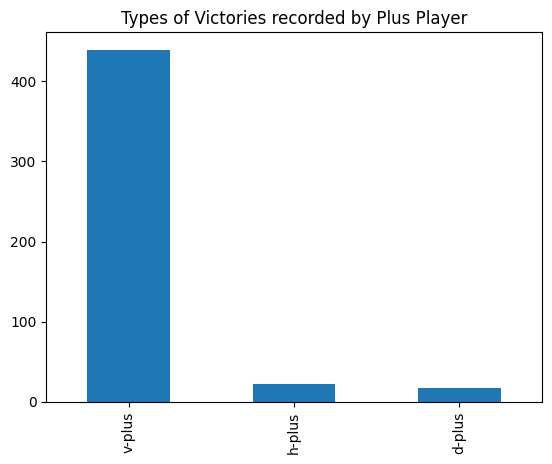

In [98]:
winners_series = pd.Series(winners)
winners_sums = winners_series.value_counts()
ax = winners_sums.filter(like='plus').plot(kind='bar')
ax.set_title("Types of Victories recorded by Plus Player")

Text(0.5, 1.0, 'Types of Victories recorded by Minus Player')

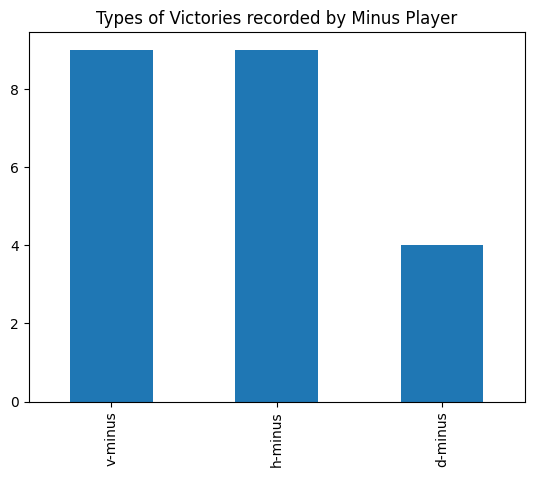

In [99]:
ax1 = winners_sums.filter(like='minus').plot(kind='bar')
ax1.set_title("Types of Victories recorded by Minus Player")

In [19]:
# mod.save('models/first_opponent')

## Train new network against new opponent

In [91]:
# mod2 = create_model(6, 7)
# mod2.summary()
mod2 = tf.keras.models.load_model('models/second_opp')

In [111]:
# fit new model against first model
ngames = 500
batch_size = 25
winners = []

for game in range(ngames):
    winner, b_array, a_array, r_array, p_array = play1opp(mod2, mod) # play game
    
    # record outcomes
    rewards = np.array(r_array)
    actions = np.array(a_array)
    boards = np.array(b_array)
    winners.append(winner)
    
    nboards = len(boards) # get num of turns
    
    disc_rewards = discount_rewards(rewards) # discount rewards from game

    actions = actions.reshape(nboards, 1, 1) # reshape actions for tf model
    
    
    #### COMMENT THIS IF RERUNNING
    # mod2.fit(boards, actions, epochs = 5, batch_size = batch_size, verbose = 0, sample_weight = disc_rewards, use_multiprocessing = True)

# get win %
count = 0
for winner in winners:
    if 'plus' in winner:
        count +=1

win_per = count/len(winners) * 100

print(f'For {ngames} games played, our new model wins {win_per}% of games against the initial model.')

For 500 games played, our new model wins 75.0% of games against the initial model.


Text(0.5, 1.0, 'Types of Victories recorded by Plus Player')

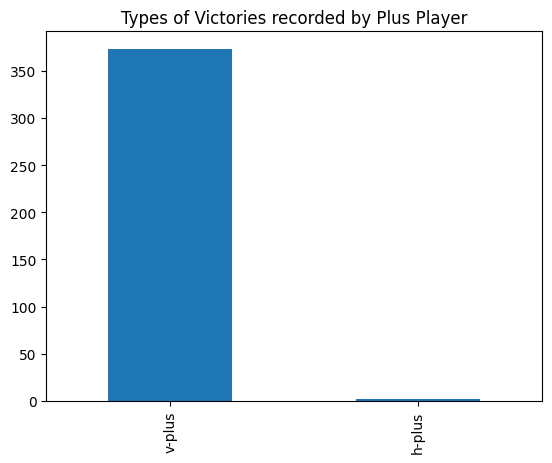

In [112]:
winners_series = pd.Series(winners)
winners_sums = winners_series.value_counts()
winners_sums = winners_series.value_counts()
ax = winners_sums.filter(like='plus').plot(kind='bar')
ax.set_title("Types of Victories recorded by Plus Player")

Text(0.5, 1.0, 'Types of Victories recorded by Minus Player')

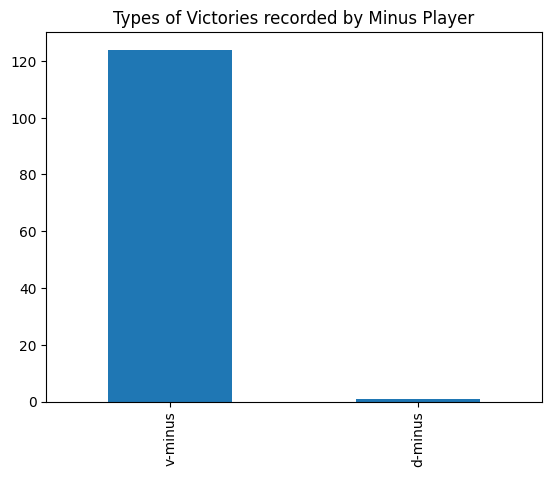

In [113]:
ax1 = winners_sums.filter(like='minus').plot(kind='bar')
ax1.set_title("Types of Victories recorded by Minus Player")

In [22]:
#mod2.save('models/second_opp')

INFO:tensorflow:Assets written to: models/second_opp/assets


INFO:tensorflow:Assets written to: models/second_opp/assets


# Check performance of Model 2 against opponent playing at random

In [118]:
# check performance against random oppon
ngames = 500
batch_size = 25
winners = []
for game in range(ngames):
    winner, b_array, a_array, r_array, p_array = play1random(mod2)
    winners.append(winner)
    
count = 0
for winner in winners:
    if 'plus' in winner:
        count +=1

win_per = count/len(winners) * 100

print(f'For {ngames} games played, our new model wins {win_per}% of the time against an opponent playing at random.')

For 500 games played, our new model wins 96.39999999999999% of the time against an opponent playing at random.


Text(0.5, 1.0, 'Types of Victories recorded by Plus Player')

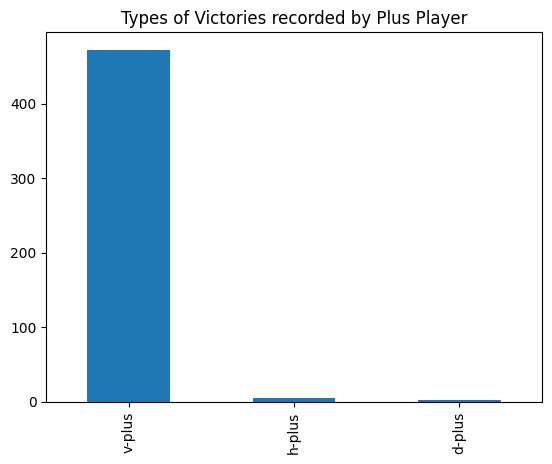

In [116]:
winners_series = pd.Series(winners)
winners_sums = winners_series.value_counts()
ax = winners_sums.filter(like='plus').plot(kind='bar')
ax.set_title("Types of Victories recorded by Plus Player")

Text(0.5, 1.0, 'Types of Victories recorded by Minus Player')

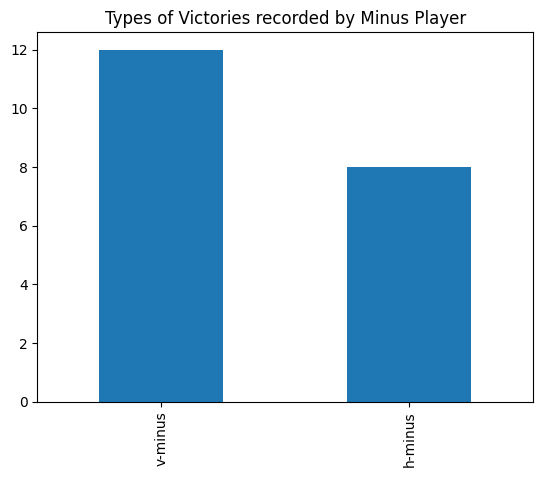

In [117]:
ax1 = winners_sums.filter(like='minus').plot(kind='bar')
ax1.set_title("Types of Victories recorded by Minus Player")

## Now we train these models against one another
design function to check for capping opponents

In [53]:
board = np.zeros((6, 7))
board[5, 2:4] = 1

In [55]:
board

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 1., 0., 0., 0.]])

In [54]:
board[3:, 0] = 1

In [56]:
i = 0
col = board[:, i]

In [58]:
list = np.array([1, 1, 1])

In [63]:
def find_subarray(first_arr, second_arr):
    # this function is for checking if stacks of 3 checkers are present, https://www.codevscolor.com/python-check-subarray-in-array
    first_ptr = 0
    second_ptr = 0

    first_arr_len = len(first_arr)
    second_arr_len = len(second_arr)

    while first_ptr < first_arr_len and second_ptr < second_arr_len:
        if first_arr[first_ptr] == second_arr[second_ptr]:
            first_ptr += 1
            second_ptr += 1

            if second_ptr == second_arr_len:
                return True

        else:
            first_ptr = first_ptr - second_ptr + 1
            second_ptr = 0

    return False

In [66]:
find_subarray(col, list)

True

In [72]:
moves = np.arange(14)

In [79]:
columns = np.arange(board.shape[1])

In [80]:
columns

array([0, 1, 2, 3, 4, 5, 6])

In [84]:
cap = np.array([0, 1, 1, 1])
cap_opp = np.array([0, -1, -1, -1])
for col in range(board.shape[1]):
    # return best move
    column = board[:, col] # get current column
    if find_subarray(column, cap) | find_subarray(column, cap_opp):

    #     move = col
    # elif find_subarray(col, cap_opp):
    #     print('opp')
    # else:
    #     print('nah')

CAP


In [ ]:
def cap_check(board, )